# Titanic Survivros Prediction

In this mission, we're going to explore a dataset from the Kaggle website in order to participate to the Kaggle Challenge.

The goal is to predict who would survive the Titanic sinking regarding a number of characteristics given in the Kaggle Datasets. First of all let's epxlore our datasets.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that the test dataframe is lacking the 'Survived' columns which will represent the column we have to predict!

### Data Cleaning

First of all let's deal with our Datasets. We need to handle the missing values, clean a few columns and create "bins" that will allow us to get better result with our algorithms.

** Handling missing values ** 

We can see that the test Dataframe has amissing value in the fare column and the train DataFrame has 2 in the Embarked one, let's deal with that by replacing them by the mean and the most common values ('S')

In [7]:
def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

** Process the age column **

The age column is continous. To help our algorithms let's create "bins" that will split the passenger into different categories related to their age.

In [8]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

** Process the fare column **

Let's do the same for the fare column!

In [9]:
def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

** Process the cabin column **

We can extract some information from the cabin column. We only need the first letter of each cabin (A,B,C...) otherwise we would have too much granularity (and too many bins, one for each cabin!)

In [10]:
def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

** Process the Titles column **

Here we decided to simplify this column with a few groups such as Officer for any army person or Royalty for aristocratic titles.

In [11]:
def process_titles(df):

    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

** Creating the dummies! ** 

Finally let's have a function that will create our dummies for each of our newly cleaned categorical columns!

In [12]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

** The Super Function ** 

We just gathered all those functions into one to apply it to each dataframe

In [13]:
def gathered_func(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df) 
    df = process_cabin(df)
    columns = ["Age_categories", "Fare_categories","Title", "Cabin_type","Sex"]
    df = create_dummies(df,columns)
    return df

In [14]:
train = gathered_func(train)
holdout = gathered_func(test)

Now that we have two cleaned datasets, let's think about the next steps

### How to optimize our predictions?

Those are the steps we are going to repeat in order to achieve the best results possible.

- Data exploration, to find patterns in the data
- Feature engineering, to create new features from those patterns or through pure experimentation
- Feature selection, to select the best subset of our current set of features
- Model selection/tuning, training a number of models with different hyperparameters to find the best performer.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

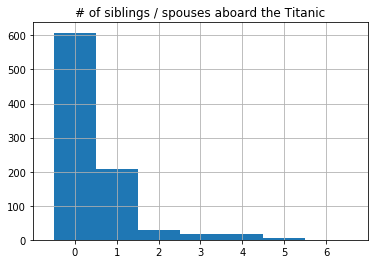

In [15]:
bins = np.arange(7) - 0.5

plt.hist(train['SibSp'],bins)
plt.xticks(range(7))
plt.title('# of siblings / spouses aboard the Titanic')
plt.xlim([-1,7])
plt.grid('off')
plt.show()

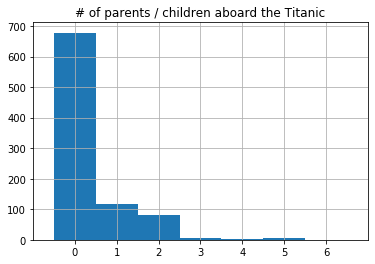

In [16]:
bins = np.arange(7) - 0.5
    
plt.hist(train['Parch'],bins)
plt.xticks(range(7))
plt.title('# of parents / children aboard the Titanic')
plt.xlim([-1,7])
plt.grid('off')

plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

Let's use a pivot tables to look at the survival rate for different values of the columns

In [17]:
pivot_sibsp = pd.pivot_table(train, index = 'SibSp', values = 'Survived')
pivot_parch = pd.pivot_table(train, index = 'Parch', values = 'Survived')

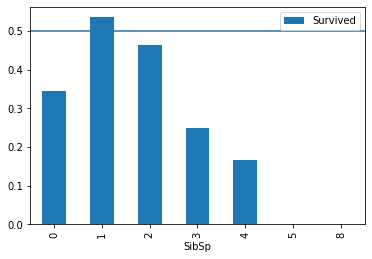

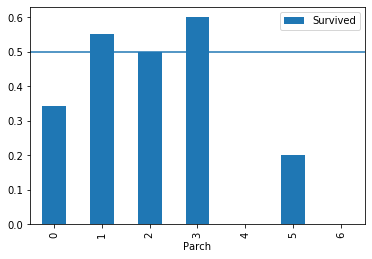

In [18]:
pivot_sibsp.plot.bar()
plt.axhline(0.5)

pivot_parch.plot.bar()
plt.axhline(0.5)
plt.show()

It seems like having 1 Sibling or Spouse might have increase a bit  your chances of survival, so did having 1 or 3 children or parents onboard!What if we sum those two columns and take into account the whole family?

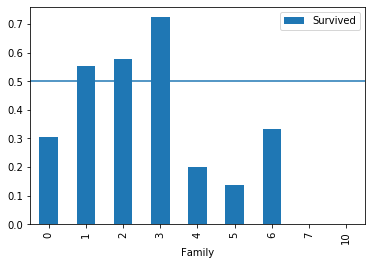

In [19]:
family_cols = ["SibSp","Parch","Survived"]
family = train[family_cols].copy()
family['Family'] = family['SibSp'] + family['Parch']
pivot_family = pd.pivot_table(family, index = 'Family', values = 'Survived')
pivot_family.plot.bar()
plt.axhline(0.5)
plt.show()

Having 1 to 3 family members seemed to be an good idea regarding those result!

However, the majority of the passengers had no family, and their survival rate is only around 30%, which is pretty low!

### New Features ###

Now we can focus on create new features that will help uor algorithms being more accurate!

The previous step gave us the idea of creating a new column with those values : 

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [20]:
def isalone(df):
    for idx,row in df.iterrows():
        if (df.loc[idx,'SibSp'] == 0) & (df.loc[idx,'Parch'] == 0):
            df.loc[idx,'isalone'] = 1
        else : 
            df.loc[idx,'isalone'] = 0
    return df

In [21]:
train = isalone(train)
holdout = isalone(holdout)

### Selecting the Best-Performing Features ###

Now let's select the best features for our algorithms!
Let''s create a function that will use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination. We will begin with the Random Forest Algorithm.

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
    
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis = 1)
    all_X = df.drop(columns = ['PassengerId',"Survived"])
    all_y = df['Survived']
    rfc = RandomForestClassifier(random_state = 1)
    selector = RFECV(rfc,cv = 10)
    selector.fit(all_X,all_y)
    best_columns = all_X.columns[selector.support_]
    print(best_columns)
    return best_columns

In [23]:
best_features = select_features(train)

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Choosing the model and tuning it! ###

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [32]:
from  sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [{
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {"n_neighbors": range(1,20,2),
             "weights": ["distance", "uniform"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "p": [1,2]}
            },
        {"name": "LogisticRegression",
        "estimator": LogisticRegression(max_iter=1000000),
        "hyperparameters":
            {"solver": ["newton-cg", "lbfgs", "liblinear"]}
            },
        {"name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {"n_estimators": [4, 6, 9],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 5, 10],
             "max_features": ["log2", "sqrt"],
             "min_samples_leaf": [1, 5, 8],
             "min_samples_split": [2, 3, 5]}
            }]
    for model in models:
        print(model["name"])
        go = model["estimator"]
        grid = GridSearchCV(go, param_grid = model["hyperparameters"], cv = 10)
        grid.fit(all_X,all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        print("Best score: {}".format(model['best_score']))
        print("Best parameters:{}".format(model['best_params']))

    return models
        

In [33]:
result_models = select_model(train,best_features)

KNeighborsClassifier


C:\Users\Pikto\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.7755331088664422
Best parameters:{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
LogisticRegression
Best score: 0.8204264870931538
Best parameters:{'solver': 'liblinear'}
RandomForestClassifier
Best score: 0.835016835016835
Best parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}


### Submission to Kaggle ###

Now that we have our best model it's time to make our submission to Kaggle!

Let's create a last function that will directly apply our sleect_model function to the test dataset (holdout) and create a csv file out of the results to send it to Kaggle!

In [34]:
def save_submission(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

In [35]:
best_model = result_models[2]['best_model']
save_submission(best_model,best_features )